### Dateset

- [Natural Earth’s physical vectors](https://www.naturalearthdata.com/downloads/50m-physical-vectors/50m-physical-labels/) [[Github]](https://github.com/nvkelso/natural-earth-vector) (version 4.1.0)

### Package

- [geopandas](https://geopandas.org/)
- [shapely](https://shapely.readthedocs.io/en/stable/manual.html) (package for computational geometry)
- [rasterio](https://rasterio.readthedocs.io/en/latest/intro.html) (For accessing the many different kind of raster data files used in the GIS field)

### Reference
- Elsen, P. R., & Tingley, M. W. (2015). Global mountain topography and the fate of montane species under climate change. Nature Climate Change, 5(8), 772-776.

In [1]:
import numpy as np
import os
from scipy.stats import skew

import litho1pt0 as litho

import rasterio
from rasterio.mask import mask
import geopandas
import shapely
from osgeo import gdal
from osgeo import osr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
%matplotlib inline
#%matplotlib notebook

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def array2geotiff_yx(fname, data, latRange, lonRange, dtype):   

    """
    save GeoTiff file from the array of dem data
    input:
    fname: save file name
    data: elevation data, an array in size of (n_lat,n_lon) 
    latRange: range of latitude, an array as [minlat,maxlat]
    lonRange: range of longitude, an array as [minlon,maxlon]
    dtype: dtype in gdal, as gdal.GDT_Byte or gdal.GDT_Float32
    """   
    nx = data.shape[1]
    ny = data.shape[0]
    xmin,xmax,ymin,ymax = [lonRange[0],lonRange[1],latRange[0],latRange[1]]
    dx = (xmax - xmin) / float(nx)
    dy = (ymax - ymin) / float(ny)
    geotransform = (xmin, dx, 0, ymax, 0, -dy)
    dst = gdal.GetDriverByName('GTiff').Create(fname, nx, ny, 1, dtype)
    dst.SetGeoTransform(geotransform) 
    dst.GetRasterBand(1).WriteArray(data)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    #srs.ImportFromEPSG(32662)  
    dst.SetProjection(srs.ExportToWkt())  
    dst.FlushCache() 

In [3]:
outputfile = "Output_3_01_01_MountainShape_plot/"
outputPath = os.path.join(os.path.abspath("."),outputfile) 
if not os.path.exists(outputPath):
    os.makedirs(outputPath)
    
# parameters for cartopy
rivers    = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',edgecolor='Blue', facecolor="none")
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',edgecolor=(0.0,0.0,0.0),facecolor="none")
prj_base  = ccrs.PlateCarree()

# parameters for plot
xticks_global = np.arange(-180,180+10,60)
yticks_global = np.arange(-90,90+10,30)
xticks_area = np.arange(-180,180+2.5,2.5)
yticks_area = np.arange(-90,90+2.5,2.5)
xticks_area1 = np.arange(-180,180+5,5)
yticks_area1 = np.arange(-90,90+5,5)
dpi = 150

In [4]:
dlon,dlat = 5/60,5/60
minlon,maxlon,minlat,maxlat = -180+dlon/2,180-dlon/2,-90+dlat/2,90-dlat/2
nlon,nlat = int((maxlon-minlon)/dlon)+1,int((maxlat-minlat)/dlat)+1

lons_base = np.linspace(minlon,maxlon,nlon)
lats_base = np.linspace(minlat,maxlat,nlat)
lonv_base, latv_base = np.meshgrid(lons_base, lats_base, indexing='xy')

In [5]:
lons_base[0],lats_base[0]

(-179.95833333333334, -89.95833333333333)

In [6]:
lons_base = np.linspace(minlon,maxlon,nlon)
lats_base = np.linspace(minlat,maxlat,nlat)
lonv_base, latv_base = np.meshgrid(lons_base, lats_base, indexing='xy')

# load topo and crust thickness from litho1.0
l1 = litho.layer_depth(lat=latv_base, lon=lonv_base, layerID="WATER-BOTTOM")*0.001
l2 = litho.layer_depth(lat=latv_base, lon=lonv_base, layerID="CRUST1-TOP")*0.001
l3 = litho.layer_depth(lat=latv_base, lon=lonv_base, layerID="CRUST3-BOTTOM")*0.001

# ls1 = litho.layer_depth(lat=latv_base, lon=lonv_base, layerID="SEDS3-BOTTOM")*0.001
# ls2 = litho.layer_depth(lat=latv_base, lon=lonv_base, layerID="SEDS1-TOP")*0.001
# sthickness = (ls1 - ls2)

# ls1 = litho.layer_depth(lat=latv_base, lon=lonv_base, layerID="ICE-BOTTOM")*0.001
# ls2 = litho.layer_depth(lat=latv_base, lon=lonv_base, layerID="ICE-TOP")*0.001
# ice =  (ls1 - ls2)

In [7]:
data_topo = (-l1)       # unit[km] exclude ice
data_ct = (l3 - l1)     # unit[km] include sediment

fname_topo = "data_topo.tif"
fname_ct = "data_ct.tif"

array2geotiff_yx(fname_topo , np.flipud(data_topo), (minlat,maxlat), (minlon,maxlon), gdal.GDT_Float32)
array2geotiff_yx(fname_ct, np.flipud(data_ct), (minlat,maxlat), (minlon,maxlon), gdal.GDT_Float32)

In [8]:
# mountains for plorting
names_shp = ["ALPS", "PYRENEES", "ZAGROS MOUNTAINS",  "PLATEAU OF TIBET","HIMALAYAS",]
names_label = ["Alps", "Pyrenees", "Zagros", "Tibet plateau","Himalaya"]
colors_mtn = ["blue","red","green","yellow","orange"]

In [9]:
fname_shp = "../Data/ne_50m_geography_regions_polys/ne_50m_geography_regions_polys.shp"
shp = geopandas.read_file(fname_shp)
shp_Unitm = shp.to_crs("EPSG:32662")

index = []
for jj,name_mtn in enumerate(names_shp):
    for ii, name in enumerate(shp.name):
        if name == name_mtn:
            print("The index of {}: {}".format(name_mtn,ii))
            index.append(ii)

The index of ALPS: 27
The index of PYRENEES: 222
The index of ZAGROS MOUNTAINS: 80
The index of PLATEAU OF TIBET: 48
The index of HIMALAYAS: 31


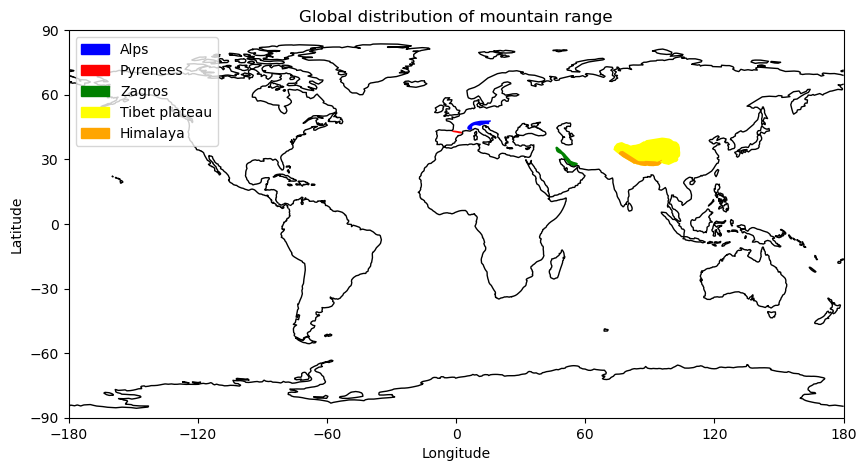

In [10]:
fname_fig="Global distribution of mountain range"
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=prj_base)
ax.set(xlabel='Longitude', ylabel='Latitude',xticks=xticks_global,yticks=yticks_global,title=fname_fig)
ax.set_global()
crs = prj_base

for ii, i in enumerate(index):
    geom_type= shp.geom_type[i] 
    if geom_type == 'MultiPolygon':
        sp = cartopy.feature.ShapelyFeature(shp.geometry[i], crs)
    elif geom_type == 'Polygon': 
        sp = cartopy.feature.ShapelyFeature([shp.geometry[i]], crs)  
    else:
        pass
    ax.add_feature(sp,facecolor=colors_mtn[ii])

color  = colors_mtn 
labels = names_label
patches = [ mpl.patches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 
ax.legend(handles=patches, loc='upper left') 
#ax.legend(handles=patches, bbox_to_anchor=(0.60,0.20), ncol=1) #loc='upper left') 
ax.add_feature(coastline, linewidth=1.0, edgecolor="Black", zorder=3)
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

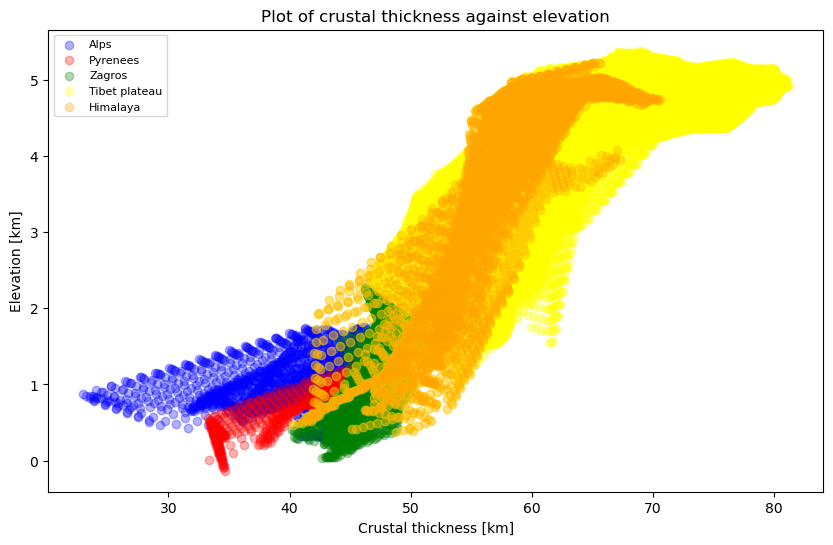

In [11]:
fname_fig = "Plot of crustal thickness against elevation"

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set(title=fname_fig)

for ii, i in enumerate(index):
        geom = shp.geometry[i]
        geom_map = [shapely.geometry.mapping(geom)]
        geom_name = shp.name[i]

        with rasterio.open(fname_topo) as src:
             out_image, out_transform = mask(src, geom_map, crop=True)
        data = out_image[0,:,:]
        no_data = 0.
        row, col = np.where(data != no_data ) 
        elev = np.extract(data != no_data, data)
        
        with rasterio.open(fname_ct) as src:
             out_image, out_transform = mask(src, geom_map, crop=True)
        data = out_image[0,:,:]
        no_data = 0.
        row, col = np.where(data != no_data ) 
        ct = np.extract(data != no_data, data)

        ax.scatter(ct,elev,color=colors_mtn[ii], alpha=0.3,label=names_label[ii])
ax.set_xlabel("Crustal thickness [km]")
ax.set_ylabel("Elevation [km]")
#ax.grid(axis="y")
plt.legend(loc = 'upper left',prop = {'size':8}) 
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

### Compare the topo data from litho1.0 and ETOPO5 

In [19]:
globalmarble      = gdal.Open("data_topo.tif")
globalmarble_img  = globalmarble.ReadAsArray()*1000

globalmarble1      = gdal.Open("../Data/ETOPO5.tif")
globalmarble_img1  = globalmarble1.ReadAsArray()

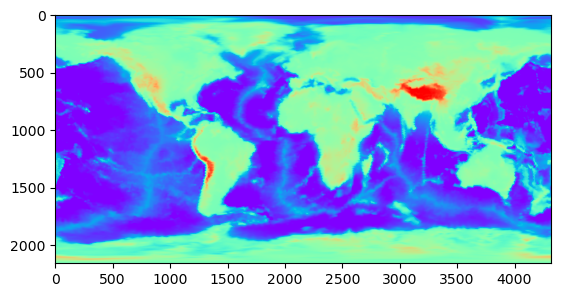

In [20]:
plt.imshow(globalmarble_img,cmap=cm.rainbow,vmin=-5000,vmax=5000)

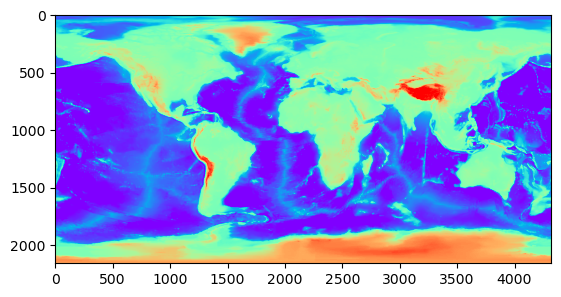

In [21]:
plt.imshow(globalmarble_img1,cmap=cm.rainbow,vmin=-5000,vmax=5000)

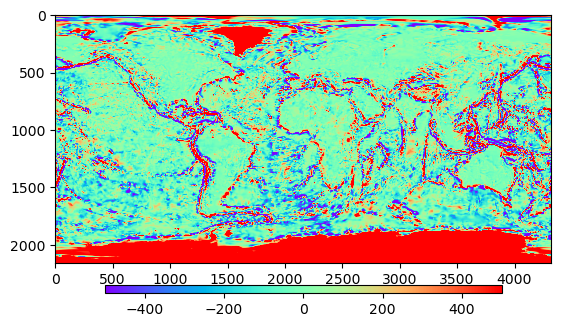

In [22]:
m = plt.imshow(globalmarble_img1-globalmarble_img,cmap=cm.rainbow,vmin=-500,vmax=500)
cbr = plt.colorbar(mappable=m, orientation='horizontal',pad=0.06,shrink=0.8, aspect=50)

/tmp/ipykernel_446437/458669893.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.scatter(0,0,s=1,label="mean: "+str(np.int(elev.mean())),alpha=0)
/tmp/ipykernel_446437/458669893.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

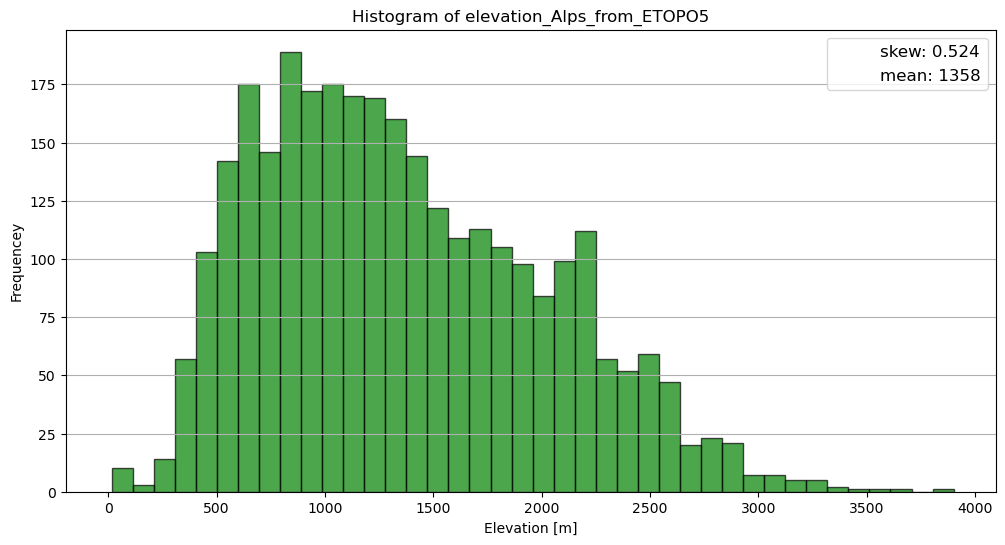

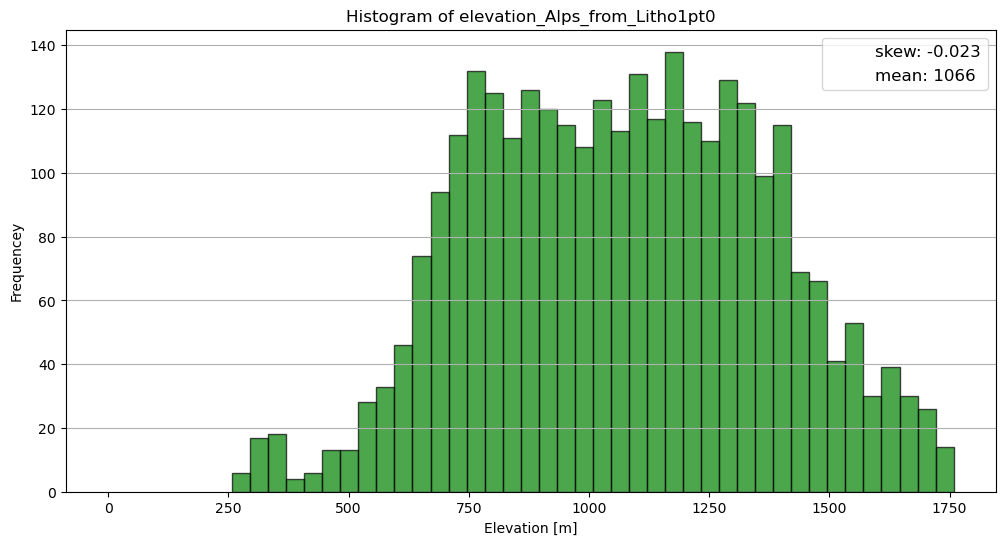

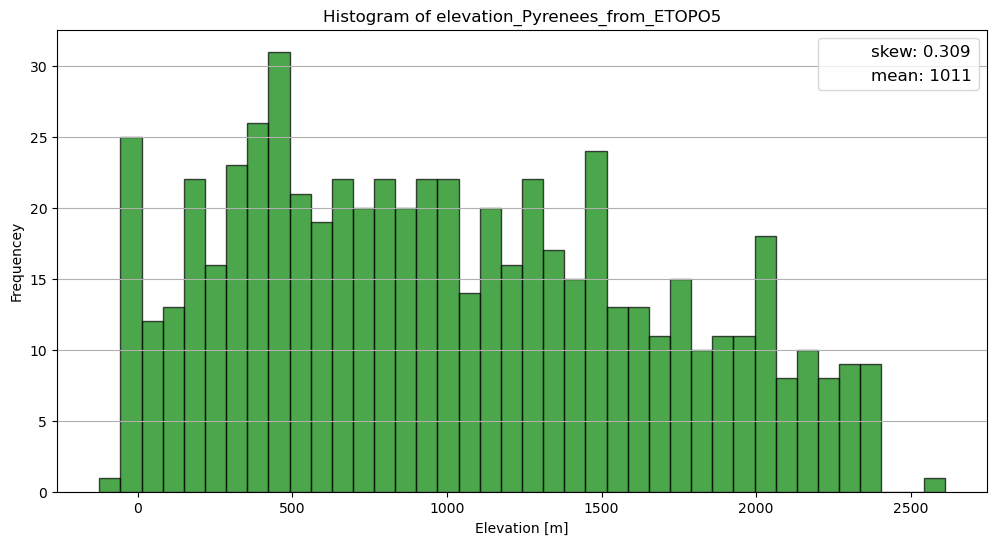

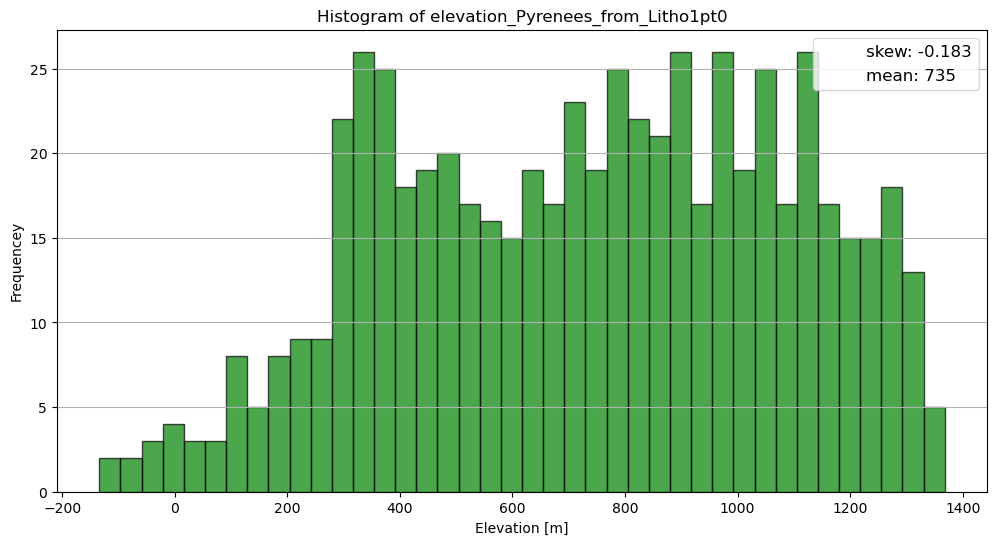

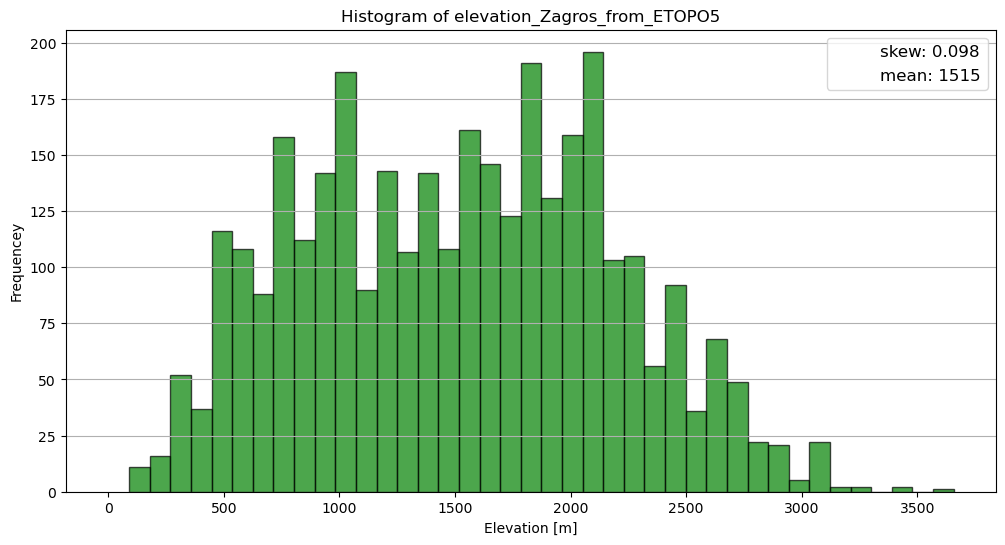

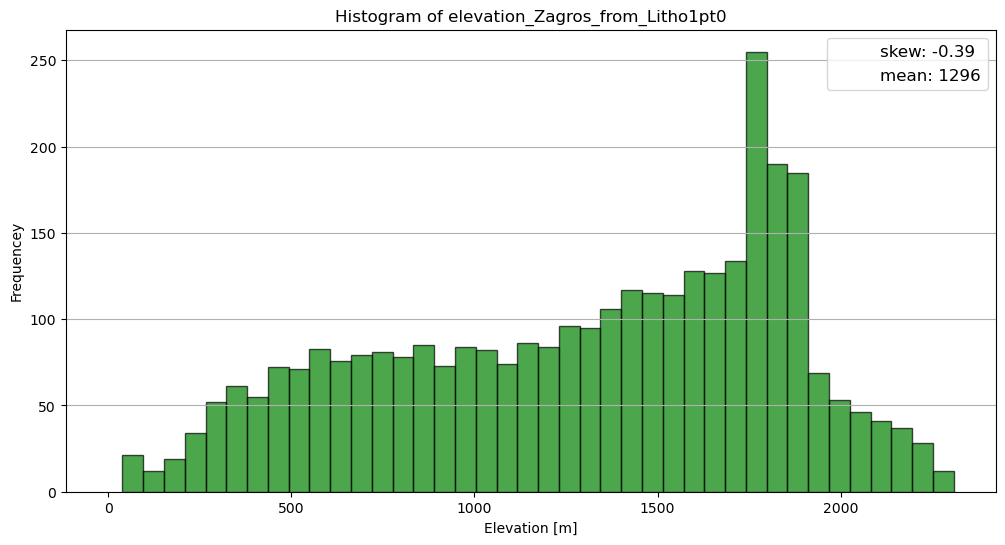

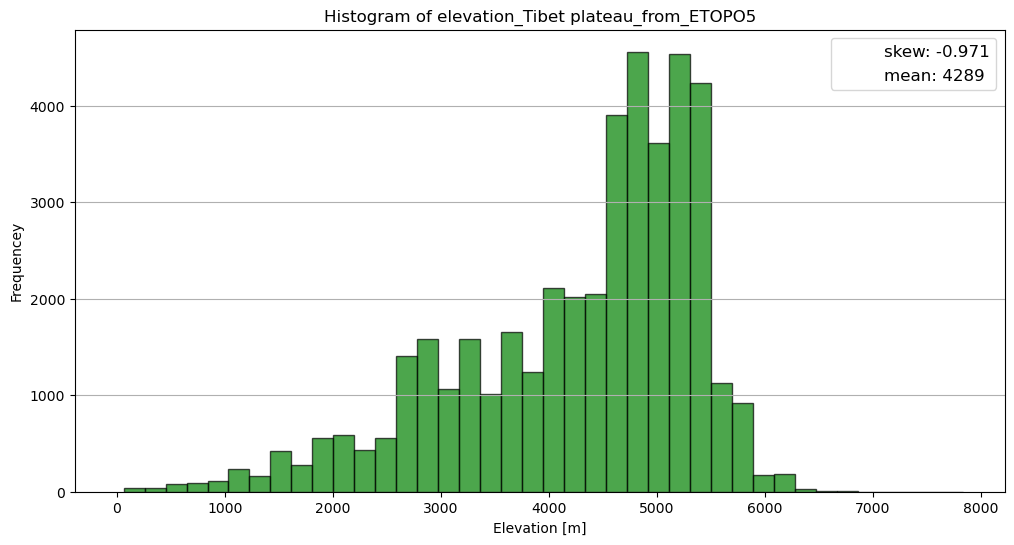

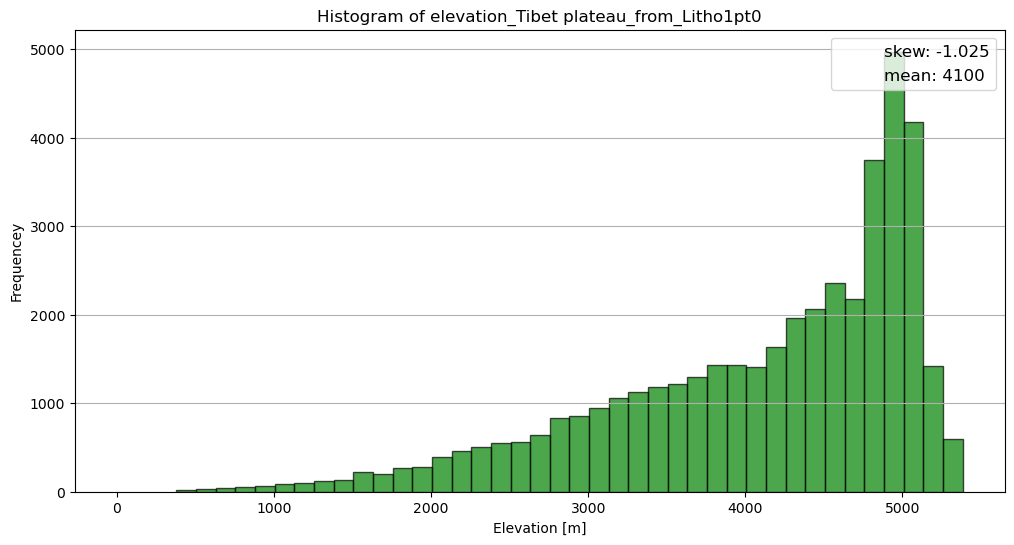

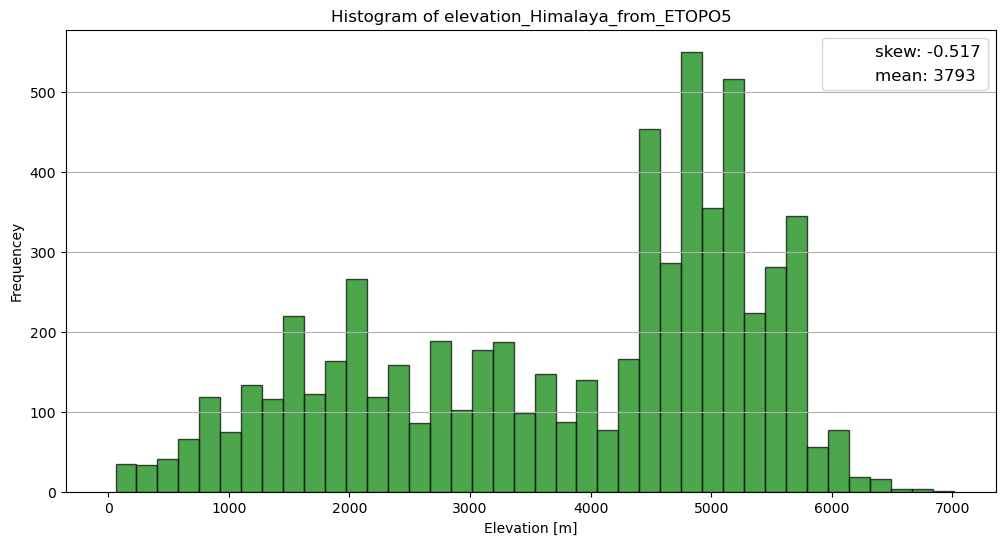

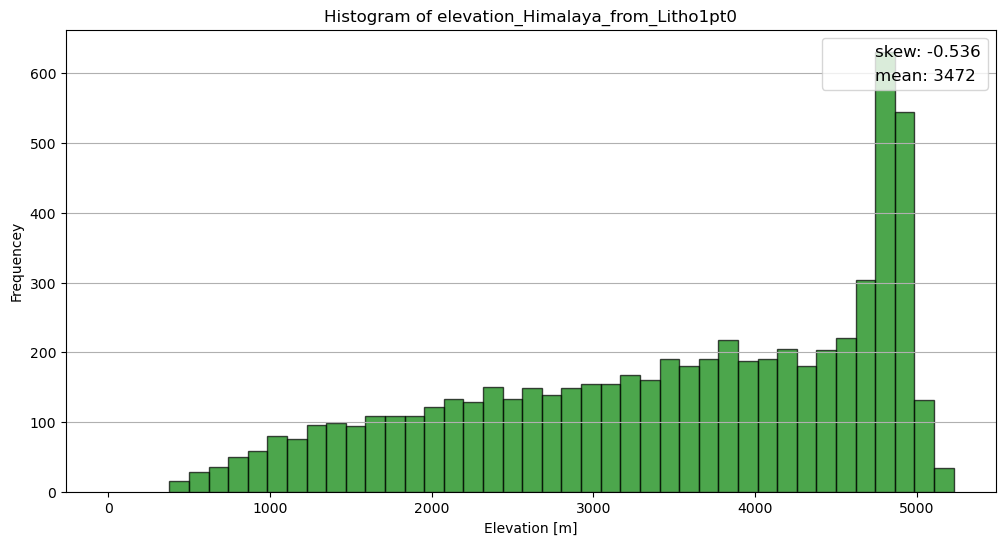

In [23]:
for ii, i in enumerate(index):
    
    geom = shp.geometry[i]
    geom_map = [shapely.geometry.mapping(geom)]
    geom_name = shp.name[i]
        
    fname_src =  "../Data/ETOPO5.tif"
    with rasterio.open(fname_src) as src:
         out_image, out_transform = mask(src, geom_map, crop=True)
        #plt.imshow(out_image[0,:,:])

    data = out_image[0,:,:]
    no_data = 0.
    row, col = np.where(data != no_data ) 
    elev = np.extract(data != no_data, data)


    fname_fig = "Histogram of elevation_"+names_label[ii]+"_from_ETOPO5"
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    ax.hist(elev,bins=40, facecolor="green", edgecolor="black", alpha=0.7)
    ax.set_xlabel("Elevation [m]")
    ax.set_ylabel("Frequencey")
    ax.grid(axis="y")
    ax.set_title(fname_fig)
    ax.scatter(0,0,s=1,label="skew: "+str(np.around(skew(elev),decimals=3)),alpha=0)
    ax.scatter(0,0,s=1,label="mean: "+str(np.int(elev.mean())),alpha=0)
    plt.legend(loc = 'upper right',prop = {'size':12}) 
    plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')
    
    
    fname_src =  fname_topo
    with rasterio.open(fname_src) as src:
         out_image, out_transform = mask(src, geom_map, crop=True)
        #plt.imshow(out_image[0,:,:])

    data = out_image[0,:,:]
    no_data = 0.
    row, col = np.where(data != no_data ) 
    elev = np.extract(data != no_data, data)*1000


    fname_fig = "Histogram of elevation_"+names_label[ii]+"_from_Litho1pt0"
    fig, ax = plt.subplots(1, 1, figsize=(12,6))
    ax.hist(elev,bins=40, facecolor="green", edgecolor="black", alpha=0.7)
    ax.set_xlabel("Elevation [m]")
    ax.set_ylabel("Frequencey")
    ax.grid(axis="y")
    ax.set_title(fname_fig)
    ax.scatter(0,0,s=1,label="skew: "+str(np.around(skew(elev),decimals=3)),alpha=0)
    ax.scatter(0,0,s=1,label="mean: "+str(np.int(elev.mean())),alpha=0)
    plt.legend(loc = 'upper right',prop = {'size':12}) 
    plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [17]:
# from osgeo import gdal
# fname = "../Data/ETOPO5.tif"
# gtiff = gdal.Open(fname)
# width = gtiff.RasterXSize
# height = gtiff.RasterYSize
# gt = gtiff.GetGeoTransform()
# img = np.flipud(gtiff.GetRasterBand(1).ReadAsArray())

# minlon,maxlat = gt[0],gt[3]
# dlon,dlat = gt[1], -gt[5]   #dlon,dlat = 5/60,5/60
# nlon,nlat = img.shape[1],img.shape[0]
# maxlon = minlon+dlon*nlon
# minlat = maxlat-dlat*nlat
# extent = (minlon,maxlon,minlat,maxlat)

# lons_base = np.linspace(minlon,maxlon,nlon)
# lats_base = np.linspace(minlat,maxlat,nlat)
# lonv_base, latv_base = np.meshgrid(lons_base, lats_base, indexing='xy')

# # extent_topo0 = extent
# # dlon_topo0,dlat_topo0 = dlon,dlat
# # data_topo0 = img

In [18]:
# lons_base[0],lats_base[0]